# Parser for HWDDDA Project

In [1]:
#! pip install pandas
#! pip install matplotlib
#! pip install vectormath
#! pip install pyvista
#! pip install vtk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectormath as vmath
import pyvista as pv
from datetime import datetime

import panel
panel.extension("vtk")
pv.set_plot_theme("document")

Read the datafile and stick it in a data frame.

The data file starts with a calibration block (not currently parsing that calibration, just skipping it). TODO: need to apply proper calibration to the data

Since we have a bunch of data files, wrap this parsing into a function so we can cleanly call it once for each file.

In [3]:
def LoadData(fname, startrow=0, stoprow=999999999999):
    filename = "../../data/preliminary/" + fname

    #TODO: need to use readable column names to avoid confusion
    headers = ["dt", "Sch", "Ch0", "Ch1", "Ch2", "Ch3", "Ch4", "Ch5", "Ch6", "Ch7", "Ch8"]

    df = pd.read_csv(filename, 
                     header=None, names=headers, 
                     skiprows=12+startrow,  #skip the calibration block for now
                     nrows=stoprow-startrow,
                     low_memory=False)
    df["cnt"] = np.arange(len(df)) #add a counter column for easy plotting

    print("# of rows:", len(df))
    #print(df)
    #print(df.head(5))
    
    return(df)

Only run one of these, or just make sure the last one is the one you want to use.

Try and get the start/stop row index to cover legitimate data (i.e. exclude bad startup and shutdown data if present).

In [4]:
df = LoadData("file_43_calibrated_20180516102829.csv") #this one has a bunch of empty values

# of rows: 1048564


In [5]:
df = LoadData("File_18_1002_Calibrated_20190510135452.csv", 0, 100)

# of rows: 100


In [6]:
df = LoadData("Thorman B-3/File_35_1002_Calibrated_20190801103404.csv", 11000, 9999999)

# of rows: 24932


In [7]:
df.describe() #get some stats

dt           Sch           Ch0           Ch1           Ch2  \
count  24932.0  24932.000000  24932.000000  24932.000000  24932.000000   
mean       5.0    959.997593  16263.590286   8236.692338  17912.222806   
std        0.0      0.048998     44.356975      2.393478    398.115090   
min        5.0    959.000000  16196.000000   8232.130000  12210.000000   
25%        5.0    960.000000  16224.000000   8235.200000  17729.000000   
50%        5.0    960.000000  16256.000000   8236.740000  17926.000000   
75%        5.0    960.000000  16297.000000   8238.280000  18112.000000   
max        5.0    960.000000  16360.000000   8240.840000  22161.000000   

                Ch3           Ch4           Ch5           Ch6           Ch7  \
count  24932.000000  24932.000000  24932.000000  24932.000000  24932.000000   
mean   17950.085272  24379.781606   6733.244665  12990.770095   8798.614191   
std      325.050398    220.728050      9.362538     20.450080     20.942330   
min    14237.000000  22578.000000   6704.000000  12940.000000   8758.000000   
25%    17825.000000  24215.000000   6726.000000  12976.000000   8784.000000   
50%    17955.000000  24380.000000   6733.000000  12991.000000   8792.000000   
75%    18086.000000  24506.000000   6740.000000  13005.000000   8807.000000   
max    21077.000000  25430.000000   6765.000000  13050.000000   8864.000000   

       Ch8           cnt  
count  0.0  24932.000000  
mean   NaN  12465.500000  
std    NaN   7197.392792  
min    NaN      0.000000  
25%    NaN   6232.750000  
50%    NaN  12465.500000  
75%    NaN  18698.250000  
max    NaN  24931.000000

Now we can plot the data. matplotlib is a bit more interactive when run locally, but this should be good enough for now.
Just plot the individual components to get an overview.

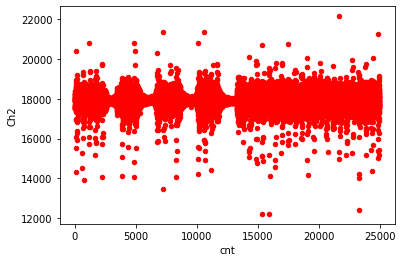

In [8]:
df.plot(kind='scatter',x='cnt',y='Ch2',color='red')
plt.show()

Which channel is this?

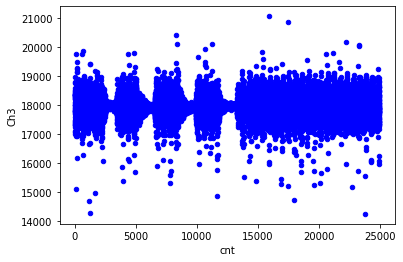

In [9]:
df.plot(kind='scatter',x='cnt',y='Ch3',color='blue')
plt.show()

I think this is Z

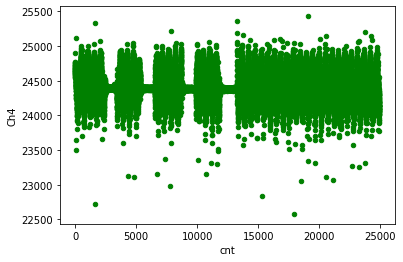

In [10]:
df.plot(kind='scatter',x='cnt',y='Ch4',color='green')
plt.show()

Lets get the gravity vector now. This should also be the direction of tool travel. Ideally, the samples that are not part of normal motion should have been eliminated above, and we should have enough samples to wash out partial strokes at the beginning/end.

In [11]:
gravityv = vmath.Vector3(df["Ch3"].mean(), df["Ch4"].mean(), df["Ch5"].mean())
print("Gravity vector:", gravityv)

#not sure if these next few lines are needed....

#I suck at python, but this should be an array of x,y,z vectors
arrxyz = np.reshape((np.array(df["Ch3"]), np.array(df["Ch4"]), np.array(df["Ch5"])), (3, -1)).transpose()


#load them into a Vector3Array to operate on
v_array = vmath.Vector3Array(arrxyz)

Gravity vector: [17950.08527194 24379.78160597  6733.24466549]


Give a 3D view of that gravity vector... should roughly indicate the orientation of the tool.

In [12]:
pg = pv.Plotter()
pg.set_background("gray")
veczero = np.array([0., 0., 0.])

#TODO: probably want to orient these so direction of travel is up/down on this plot
vecgrav = np.array([df["Ch2"].mean(), df["Ch3"].mean(), df["Ch4"].mean()])
gravline = np.stack((veczero, vecgrav))
_ = pg.add_lines(gravline, color="red")


#because I cant figure out how to plot the proper grid in pyvista. This is a bit hacky.
vertline = np.stack((veczero, np.array([0., 32000., 0.])))
_ = pg.add_lines(vertline, color="blue")


horiline = np.stack((veczero, np.array([32000., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((veczero, np.array([-32000., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((veczero, np.array([0., 0., 32000.])))
_ = pg.add_lines(horiline, color="green")

horiline = np.stack((veczero, np.array([0., 0., -32000.])))
_ = pg.add_lines(horiline, color="green")



_ = pg.add_axes(interactive=True, color="blue") #notebook doesnt render helper
_ = pg.show_bounds(grid="front", location="outer", all_edges=True, color="red")
pg.show_grid() #not working?

In [13]:
pg.plot()

VTK(vtkCocoaRenderWindow, height=400, sizing_mode='stretch_width')

## TODO: should apply calibration to the raw sample data

Just plot all acceleration samples. Not too helpful at this point.

In [14]:
p = pv.Plotter()
p.set_background("gray")

verts = np.column_stack((df["Ch2"], df["Ch3"], df["Ch4"]))
_ = p.add_points(verts, color="red")
_ = p.add_axes()

In [15]:
p.show()

VTK(vtkCocoaRenderWindow, height=400, sizing_mode='stretch_width')

In [16]:
pc = pv.PolyData(verts)
pc.plot(point_size=1, show_grid=True, color='red')

VTK(vtkCocoaRenderWindow, height=400, sizing_mode='stretch_width')

In [17]:
print("test")

test
